In [62]:
%load_ext lab_black

import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import admix_genet_cor
import itertools
import admix
from tqdm import tqdm
import os
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import glob
import string
from scipy import stats
import matplotlib
from typing import Union, List, Tuple
from utils import read_estimate

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [2]:
# SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp-tables.xlsx?dl=1"
SUPP_TABLE_URL = "supp-tables.xlsx"
snpset = "imputed.mafukb.005"

In [4]:
# UKB
df_trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="ukb-trait-info")
ukb_trait_list = df_trait_info[df_trait_info["in-analysis"] == "T"].id.values
ukb_name_dict = (
    df_trait_info[["id", "display-name"]].set_index("id")["display-name"].to_dict()
)

# PAGE
df_trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="page-trait-info")
page_trait_list = df_trait_info.trait.values
page_name_dict = (
    df_trait_info[["trait", "display-name"]]
    .set_index("trait")["display-name"]
    .to_dict()
)

In [5]:
dict_loglik, dict_nindiv = read_estimate(
    "imputed.mafukb.005", ukb_trait_list=ukb_trait_list, page_trait_list=page_trait_list
)

In [6]:
xs = np.linspace(0, 1, 1001)
for study in ["ukb", "page", "overall"]:
    meta_ll = 0
    for trait in dict_loglik:
        if trait not in dict_loglik:
            continue
        if (study in ["ukb", "page"]) and (trait[0] != study):
            continue
        loglik = dict_loglik[trait]
        meta_ll += loglik
    interval = admix_genet_cor.hdi(xs, meta_ll)
    print(
        f"{study}: {meta_ll.argmax() / 1000:.3g} [{interval[0]:.2g}, {interval[1]:.2g}]"
    )

ukb: 0.981 [0.91, 1]
page: 0.902 [0.85, 0.94]
overall: 0.921 [0.88, 0.95]


# Summary

In [7]:
def summarize(dict_loglik, dict_nindiv):
    df_sum = []
    meta_loglik = 0
    for study, trait in dict_loglik:
        if study == "ukb":
            trait_name = ukb_name_dict[trait]
        else:
            trait_name = page_name_dict[trait]

        if dict_loglik[(study, trait)] is None:
            df_sum.append(
                [
                    "UKBB" if study == "ukb" else "PAGE",
                    trait_name,
                    "NA",
                    "NA",
                    "NA",
                    "NA",
                ]
            )
        else:
            loglik = dict_loglik[(study, trait)]
            meta_loglik += loglik
            nindiv = dict_nindiv[(study, trait)]
            mode = loglik.argmax() / 1000
            pval = stats.chi2.sf((loglik.max() - loglik[-1]) * 2, df=1)
            interval = admix_genet_cor.hdi(xs, loglik, ci=0.95)
            if isinstance(interval, tuple):
                interval = f"[{interval[0]:.2f}, {interval[1]:.2f}]"
            elif isinstance(interval, list):
                interval = " ".join([f"[{i[0]:.2f}, {i[1]:.2f}]" for i in interval])

            df_sum.append(
                [
                    "UKBB" if study == "ukb" else "PAGE",
                    trait_name,
                    nindiv,
                    mode,
                    interval,
                    f"{pval:.2g}",
                ]
            )
    meta_interval = admix_genet_cor.hdi(xs, meta_loglik, ci=0.95)
    meta_pval = stats.chi2.sf((meta_loglik.max() - meta_loglik[-1]) * 2, df=1)
    df_sum.append(
        [
            "",
            "Meta analysis",
            "",
            meta_loglik.argmax() / 1000,
            f"[{meta_interval[0]:.2f}, {meta_interval[1]:.2f}]",
            f"{meta_pval:.2g}",
        ]
    )
    df_sum = pd.DataFrame(
        df_sum,
        columns=["Study", "Trait", "N", "Mode", "95% credible interval(s)", "p-value"],
    )
    return df_sum

In [8]:
# see 01-genome-wide-simulate-profile-likelihood/03-plot-hsq.ipynb to get this constant
scale_factor = 0.24884752564563367

In [9]:
def estimate_hsq(dict_est, scale_factor=1):
    """
    Estimate the ratio with delta method, est[0] (var_g) / [est[0] (var_g) + est[1] (var_e)]
    est: (2, ) numpy array
    est_var (2, 2) variance-covariance matrix
    """
    assert len(dict_est["est"]) == 2
    assert np.all(dict_est["est"].Source.values == ["V(G)", "V(e)"])
    est = dict_est["est"].Variance.values
    est_var = dict_est["varcov"].values

    ## method 1
    x, y = est[0], est[1]
    hsq = (x * scale_factor) / (x * scale_factor + y)

    # grad = [y / (x + y)^2, - x / (x + y)^2]
    grad = np.array(
        [
            scale_factor * y / ((scale_factor * x + y) ** 2),
            -scale_factor * x / ((scale_factor * x + y) ** 2),
        ]
    )

    ## method2
    #     x, y = est[0] * scale_factor, est[1]

    #     est_var[0, :] *= scale_factor
    #     est_var[:, 0] *= scale_factor

    #     hsq = x / (x + y)

    #     # grad = [y / (x + y)^2, - x / (x + y)^2]

    #     grad = np.array([y / ((x + y) ** 2), -x / ((x + y) ** 2)])

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return hsq, quad_form(grad, est_var)

# Read hsq estimates

In [10]:
df_hsq = {"Study": [], "Trait": [], "hsq": []}

for study in ["ukb", "page"]:
    trait_list = ukb_trait_list if study == "ukb" else page_trait_list
    for trait in trait_list:
        if study == "ukb":
            est_dir = (
                "/u/home/k/kangchen/project-UKBB/UKB-ADMIXED/02-genet-cor/"
                f"out/gcta-estimate/{trait}-sample10pc-{snpset}"
            )
        else:
            est_dir = (
                "/u/project/pasaniuc/kangchen/2021-admix-corr/experiments/"
                "03-page-genome-wide-profile-likelihood-new/out/gcta-estimate/"
                f"{trait}-sample10pc-{snpset}"
            )
        dict_est = admix.tools.gcta.read_reml(os.path.join(est_dir, f"rho100"))
        est, est_var = estimate_hsq(dict_est, scale_factor=scale_factor)

        if study == "ukb":
            trait_name = ukb_name_dict[trait]
        else:
            trait_name = page_name_dict[trait]
        df_hsq["Study"].append({"ukb": "UKBB", "page": "PAGE"}[study])
        df_hsq["Trait"].append(trait_name)
        df_hsq["hsq"].append(f"${est:.3g} \pm {np.sqrt(est_var):.2g}$")
df_hsq = pd.DataFrame(df_hsq)

In [11]:
df_sum = summarize(dict_loglik, dict_nindiv)
df_sum.to_excel("numerical.xlsx", index=False)

In [12]:
print(
    "UKB: {ukb_n_trait} traits (average N={ukb_n:.0f}). PAGE: {page_n_trait} traits (average N={page_n:.0f})".format(
        ukb_n_trait=sum(df_sum.Study == "UKBB"),
        ukb_n=df_sum[df_sum.Study == "UKBB"]["N"].mean(),
        page_n_trait=sum(df_sum.Study == "PAGE"),
        page_n=df_sum[df_sum.Study == "PAGE"]["N"].mean(),
    )
)

UKB: 26 traits (average N=3808). PAGE: 24 traits (average N=9296)


In [13]:
assert df_sum[["Study", "Trait"]].iloc[0:50].equals(df_hsq[["Study", "Trait"]])

In [14]:
df_sum["$\widehat{h_g^2}$"] = ""
df_sum.iloc[0:50, 6] = df_hsq["hsq"]

In [15]:
print(df_sum.to_latex(escape=False, index=False))

\begin{tabular}{lllrlll}
\toprule
Study &                    Trait &     N &  Mode &  95% credible interval(s) & p-value &   $\widehat{h_g^2}$ \\
\midrule
 UKBB &           Hypothyroidism &  4063 & 1.000 &              [0.05, 1.00] &       1 &  $0.0436 \pm 0.067$ \\
 UKBB &          Type 1 diabetes &  3767 & 0.381 &              [0.00, 0.95] &    0.77 & $-0.0308 \pm 0.015$ \\
 UKBB &          Type 2 diabetes &  4114 & 0.920 &              [0.06, 1.00] &    0.82 &  $0.0856 \pm 0.068$ \\
 UKBB &             Hypertension &  4127 & 0.983 &              [0.09, 1.00] &    0.93 &   $0.155 \pm 0.079$ \\
 UKBB &                   Asthma &  4079 & 1.000 &              [0.15, 1.00] &       1 &     $0.2 \pm 0.084$ \\
 UKBB &        Total cholesterol &  3898 & 0.972 &              [0.36, 1.00] &    0.81 &   $0.304 \pm 0.087$ \\
 UKBB & Diastolic blood pressure &  4017 & 1.000 &              [0.07, 1.00] &       1 &   $0.133 \pm 0.081$ \\
 UKBB &   RBC distribution width &  3925 & 1.000 &           

In [16]:
# trait that's nominally significant
display(
    df_sum[df_sum["p-value"].astype(float) < 0.05].style.set_caption(
        "Traits that are nominally significant"
    )
)

# trait that's significant after Bonferrnoni correction
display(
    df_sum[
        df_sum["p-value"].astype(float) < 0.05 / (len(df_sum) - 1)
    ].style.set_caption("Traits that are bonferroni significant")
)

,Study,Trait,N,Mode,95% credible interval(s),p-value,$\widehat{h_g^2}$
15,UKBB,BMD,1668,0.000000,"[0.00, 0.78]",0.012,$0.326 \pm 0.16$
33,PAGE,Total cholesterol,9981,0.696000,"[0.10, 0.92]",0.0053,$0.176 \pm 0.036$
47,PAGE,Height,16705,0.902000,"[0.81, 0.97]",0.0042,$0.388 \pm 0.025$
50,,Meta analysis,,0.921000,"[0.88, 0.95]",6.8e-07,


,Study,Trait,N,Mode,95% credible interval(s),p-value,$\widehat{h_g^2}$
50,,Meta analysis,,0.921000,"[0.88, 0.95]",6.8e-07,


In [17]:
df_ukb = df_sum[df_sum.Study == "UKBB"]
df_page = df_sum[df_sum.Study == "PAGE"]
df_merged = pd.merge(df_ukb, df_page, on=["Trait"], suffixes=["_ukb", "_page"])

print(f"{len(df_merged)} traits in common between UKB and PAGE")
print(
    "Spearman correlation of -log10[p] from two studies: {:.2g}".format(
        stats.spearmanr(
            df_merged["p-value_ukb"].astype(float),
            df_merged["p-value_page"].astype(float),
        )[1]
    )
)

13 traits in common between UKB and PAGE
Spearman correlation of -log10[p] from two studies: 0.13


In [18]:
shared_trait_list = [
    "Height",
    "Total cholesterol",
    "Platelet count",
    "Triglycerides",
    "BMI",
    "Type 2 diabetes",
    "White blood cell count",
    "Hypertension",
    "HDL",
    "LDL",
    "HbA1c",
    "Diastolic blood pressure",
    "Systolic blood pressure",
]
assert set(shared_trait_list) == set(df_merged["Trait"])

In [19]:
dict_joint_loglik = {t: 0 for t in shared_trait_list}
dict_joint_nindiv = {t: 0 for t in shared_trait_list}
for study, trait in dict_loglik:
    if study == "ukb":
        trait_name = ukb_name_dict[trait]
    else:
        trait_name = page_name_dict[trait]
    if trait_name in shared_trait_list:

        dict_joint_loglik[trait_name] += dict_loglik[study, trait]
        dict_joint_nindiv[trait_name] += dict_nindiv[study, trait]

dict_est = {
    trait: dict_joint_loglik[trait].argmax() / 1000 for trait in shared_trait_list
}
dict_hdi_50 = {
    trait: admix_genet_cor.hdi(xs, dict_joint_loglik[trait], ci=0.5)
    for trait in shared_trait_list
}

dict_hdi_95 = {
    trait: admix_genet_cor.hdi(xs, dict_joint_loglik[trait], ci=0.95)
    for trait in shared_trait_list
}

dict_joint_pval = {
    trait: stats.chi2.sf((loglik.max() - loglik[-1]) * 2, df=1)
    for trait, loglik in dict_joint_loglik.items()
}
df_joint_pval = pd.DataFrame(
    {"trait": dict_joint_pval.keys(), "pval": dict_joint_pval.values()}
).sort_values("pval")
assert np.all(np.array(shared_trait_list) == df_joint_pval.trait)

In [20]:
loglik_all = 0
for t in dict_loglik:
    loglik_all += dict_loglik[t]

dict_est["Meta-analysis"] = loglik_all.argmax() / 1000

dict_hdi_50["Meta-analysis"] = admix_genet_cor.hdi(xs, loglik_all, ci=0.5)
dict_hdi_95["Meta-analysis"] = admix_genet_cor.hdi(xs, loglik_all, ci=0.95)

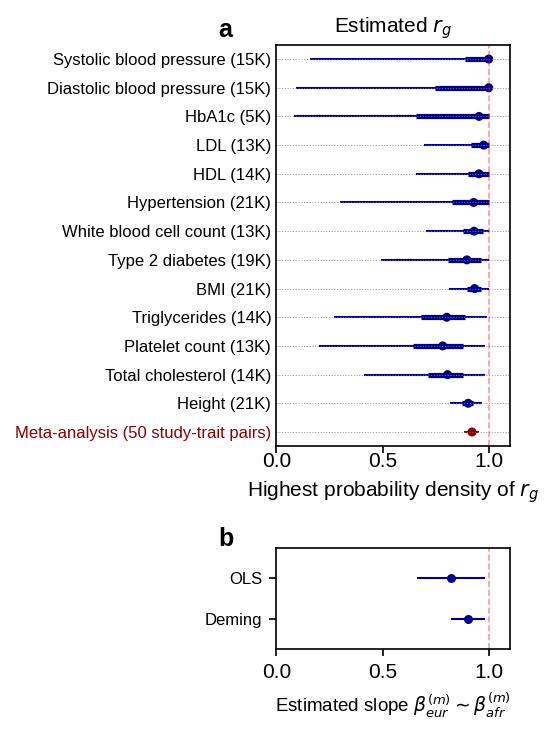

In [21]:
fig, axes = plt.subplots(
    figsize=(3.6, 5),
    dpi=150,
    nrows=2,
    gridspec_kw={"height_ratios": [4, 1]},
)

ax = axes[0]
display_list = ["Meta-analysis"] + shared_trait_list

est = [dict_est[trait] for trait in display_list]
err1_50 = [dict_est[trait] - dict_hdi_50[trait][0] for trait in display_list]
err2_50 = [dict_hdi_50[trait][1] - dict_est[trait] for trait in display_list]

err1_95 = [dict_est[trait] - dict_hdi_95[trait][0] for trait in display_list]
err2_95 = [dict_hdi_95[trait][1] - dict_est[trait] for trait in display_list]

colors = ["darkred"] + ["darkblue"] * (len(est) - 1)
errbars1 = ax.errorbar(
    y=np.arange(len(est)),
    x=est,
    xerr=(err1_50, err2_50),
    fmt=" ",
    lw=2.5,
    ecolor=colors,
)
ax.scatter(y=np.arange(len(est)), x=est, s=11, color=colors)
errbars2 = ax.errorbar(
    y=np.arange(len(est)),
    x=est,
    xerr=(err1_95, err2_95),
    fmt=" ",
    lw=1.0,
    ecolor=colors,
)

for y in np.arange(len(est)):
    ax.axhline(y=y, color="gray", ls="dotted", lw=0.5, alpha=0.8)

ax.set_xlim(0, 1.1)
ax.set_xlabel("Highest probability density of $r_g$")
ax.set_yticks(np.arange(len(est)))
ax.set_ylim(-0.5, len(est) - 0.5)
ax.set_yticklabels(
    ["Meta-analysis (50 study-trait pairs)"]
    + [
        f"{t} ({int(np.round(dict_joint_nindiv[t] / 1000))}K)" for t in display_list[1:]
    ],
    fontsize=8,
)

# annotation
ax.tick_params(left=False, pad=-1)

ax.axvline(x=1.0, color="red", ls="--", lw=0.8, alpha=0.4)
ax.set_title("Estimated $r_g$", fontsize=10, x=0.5)

# set color for the meta-analysis
ax.get_yticklabels()[0].set_color("darkred")

# annotation
ax.text(
    -0.25,
    1.02,
    "a",
    transform=ax.transAxes,
    size=12,
    weight="bold",
)


ax = axes[1]
ax.axvline(x=1.0, color="red", ls="--", lw=0.8, alpha=0.4)
df_slope = pd.DataFrame(
    {
        "label": [
            "Deming",
            "OLS",
        ],
        "mean": [
            0.90,
            0.82,
        ],
        "se": [
            0.04,
            0.08,
        ],
    }
)

ax.scatter(y=np.arange(len(df_slope)), x=df_slope["mean"], s=11, color="darkblue")
errbars = ax.errorbar(
    y=np.arange(len(df_slope)),
    x=df_slope["mean"],
    xerr=(df_slope["se"] * 2, df_slope["se"] * 2),
    fmt=" ",
    lw=1.0,
    ecolor="darkblue",
)
ax.set_yticks([0, 1])
ax.set_yticklabels(df_slope.label, fontsize=8)
ax.set_xlim(0, 1.1)
ax.set_ylim(-0.7, 1.7)
ax.set_xlabel(
    "Estimated slope $\\beta_{eur}^{(m)} \sim \\beta_{afr}^{(m)}$", fontsize=9
)
ax.text(
    -0.25,
    1.02,
    "b",
    transform=ax.transAxes,
    size=12,
    weight="bold",
)

plt.tight_layout()
plt.savefig("results/shared.pdf", bbox_inches="tight")

# consistency of the estimates using gcta / hm3


In [22]:
# consistency of the estimates using gcta / hm3
df_sum_gcta = summarize(
    *read_estimate(
        "imputed.gcta.005",
        ukb_trait_list=ukb_trait_list,
        page_trait_list=page_trait_list,
    )
)
df_sum_hm3 = summarize(
    *read_estimate(
        "hm3.mafukb.005", ukb_trait_list=ukb_trait_list, page_trait_list=page_trait_list
    )
)

250.1 ukb imputed.gcta.005 can only convert an array of size 1 to a Python scalar
250.1 ukb hm3.mafukb.005 can only convert an array of size 1 to a Python scalar
log_lymphocyte ukb hm3.mafukb.005 can only convert an array of size 1 to a Python scalar


In [22]:
df_pval = pd.DataFrame(
    {
        "default": df_sum["p-value"],
        "gcta": df_sum_gcta["p-value"],
        "hm3": df_sum_hm3["p-value"],
    }
)
# remove the meta-analysis results
df_pval = df_pval.iloc[:-1]

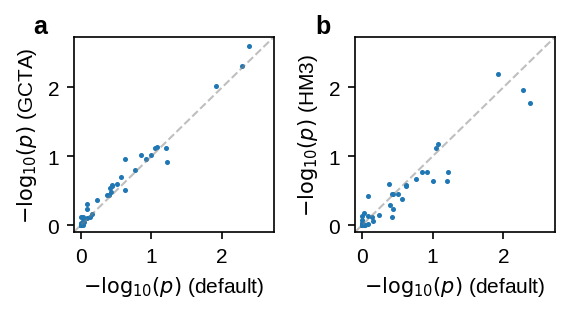

In [23]:
values = df_pval.values.flatten()
lim = -np.log10(values[values != "NA"].astype(float)).min() * 1.05

fig, axes = plt.subplots(figsize=(3.9, 2.2), dpi=150, ncols=2)
for i, compare in enumerate(["gcta", "hm3"]):
    ax = axes[i]
    df_tmp = df_pval[["default", compare]]
    df_tmp = df_tmp[~(df_tmp == "NA").any(axis=1)].astype(float)
    #     admix.plot.compare_pval(df_tmp["default"], df_tmp[compare], s=2, ax=ax)
    ax.scatter(-np.log10(df_tmp["default"]), -np.log10(df_tmp[compare]), s=2)
    ax.set_xlim(-0.1, lim)
    ax.set_ylim(-0.1, lim)
    ax.axline((0, 0), slope=1, color="gray", ls="--", alpha=0.5, lw=1.0)
    ax.set_xlabel("$-\log_{10}(p)$ (default)")
    yname = "GCTA" if compare == "gcta" else "HM3"
    ax.set_ylabel("$-\log_{10}(p)$" + f" ({yname})")
    ax.text(
        -0.2,
        1.02,
        string.ascii_lowercase[i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )

fig.tight_layout()
plt.savefig("results/robustness.pdf", bbox_inches="tight")

In [24]:
df_compare = [df_sum[["Study", "Trait", "N"]].copy()]
for name, df in zip(["Default", "GCTA", "HM3"], [df_sum, df_sum_gcta, df_sum_hm3]):
    df_compare.append(df[["Mode", "95% credible interval(s)", "p-value"]])

df_compare = pd.concat(df_compare, axis=1)
df_compare.to_excel("results/compare.xlsx", index=False)